In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# The following are imported to read "201902-citibike-tripdata.csv.zip" 
# through url which contains multiple files
import requests
import io
from zipfile import ZipFile

In [2]:
# Basic url for downloadable files of Citi Bike trip data
basic_url = 'https://s3.amazonaws.com/tripdata/'

# List of urls (second half) for specific .zip files
file_url_list = [
    "201706-citibike-tripdata.csv.zip", "201707-citibike-tripdata.csv.zip", 
    "201708-citibike-tripdata.csv.zip", "201709-citibike-tripdata.csv.zip", 
    "201710-citibike-tripdata.csv.zip", "201711-citibike-tripdata.csv.zip",
    "201712-citibike-tripdata.csv.zip", "201801-citibike-tripdata.csv.zip", 
    "201802-citibike-tripdata.csv.zip", "201803-citibike-tripdata.csv.zip", 
    "201804-citibike-tripdata.csv.zip", "201805-citibike-tripdata.csv.zip",
    "201806-citibike-tripdata.csv.zip", "201807-citibike-tripdata.csv.zip", 
    "201808-citibike-tripdata.csv.zip", "201809-citibike-tripdata.csv.zip", 
    "201810-citibike-tripdata.csv.zip", "201811-citibike-tripdata.csv.zip",
    "201812-citibike-tripdata.csv.zip", "201901-citibike-tripdata.csv.zip", 
    "201902-citibike-tripdata.csv.zip", "201903-citibike-tripdata.csv.zip", 
    "201904-citibike-tripdata.csv.zip", "201905-citibike-tripdata.csv.zip"
]

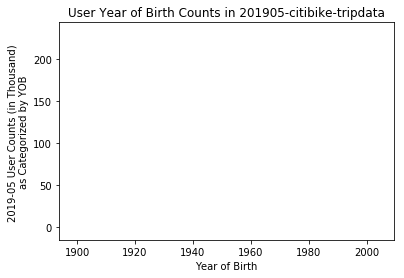

In [3]:
# Loop through "file_url_list"
for file_url in file_url_list:
    
    # .......... READ DATA .......... #
    # Concatenate "basic_url" and "file_url" to make request url
    url = basic_url + file_url
    
    # Multiple files are found in "201902-citibike-tripdata.csv.zip"
    if file_url == "201902-citibike-tripdata.csv.zip":
        # https://stackoverflow.com/questions/9419162/download-returned-zip-file-from-url
        # https://stackoverflow.com/questions/44575251/
        # reading-multiple-files-contained-in-a-zip-file-with-pandas?rq=1
        response = requests.get(url)
        zip_file = ZipFile(io.BytesIO(response.content))
        # Read monthly trip data into Pandas DataFrame
        monthly_trip_df = pd.read_csv(zip_file.open("201902-citibike-tripdata.csv"))        
    else:
        # Read monthly trip data into Pandas DataFrame
        monthly_trip_df = pd.read_csv(url)        
    
    # .......... CLEAN DATA .......... # 
    # 1. Delete unnecessary columns in the circumstance that station id info is generated separately
    monthly_trip_df.drop(["start station name", "start station latitude", "start station longitude",
        "end station name", "end station latitude", "end station longitude"], axis=1, inplace=True)
    
    # Rename column names
    monthly_trip_df = monthly_trip_df.rename(columns = {
        "tripduration": "trip-dur",
        "starttime": "s-date-time",
        "stoptime": "e-date-time",
        "start station id": "s-sta-id",
        "end station id": "e-sta-id",
        "bikeid": "bike-id",
        "usertype": "user",
        "birth year": "yob"
    })
    
    # 2. Clean "yob" data
    # Note that it can only be from the customer side should there be any BIZARRE input in the data
    # Also note that direct iterating and manipulating on "monthly_trip_df" will take forever
    # Convert "yob" column to list
    yob_list = monthly_trip_df["yob"].tolist()

    # Assign 1900 to np.nan in "yob_list" (for viz. in Tableau)
    # Also assuming that no person above the age of 90 would be able to use Citi Bike; 
    # Set yob to 1910 for viz. in Tableau
    for i in range(len(yob_list)):
        # Note that re-setting yob should be executed prior to assigning the np.nan to 1900
        if yob_list[i] < int(file_url[:4]) - 90:
            yob_list[i] = 1910 
        if np.isnan(yob_list[i]):
            yob_list[i] = 1900         
   
    # Delete "yob" column
    monthly_trip_df.drop(["yob"], axis=1, inplace=True)
    # Set "yob_list" as new "yob" column of "monthly_trip_df"
    monthly_trip_df["yob"] = yob_list
        
    # 3. Change the data type of columns to save memory usage
    monthly_trip_df["trip-dur"] = monthly_trip_df["trip-dur"].astype("int32")
    monthly_trip_df["bike-id"] = monthly_trip_df["bike-id"].astype("int32")
    monthly_trip_df["yob"] = monthly_trip_df["yob"].astype("int16")
    monthly_trip_df["gender"] = monthly_trip_df["gender"].astype("int8")        
    # For some data like 201808, "s-sta-id" and "e-sta-id" have the same indices that lack station id
    # It took more than 10 min yet without success in deleting such records in previous pilot test
    # The amounts of such records only account for roughly 0.1% of all data
    # In this scenario, I skip deleting such records for the sake of performance efficiency
    try:
        # If np.nan is in either "s-sta-id" or "e-sta-id" column, skip changing column data type
        monthly_trip_df["s-sta-id"] = monthly_trip_df["s-sta-id"].astype("int16")
        monthly_trip_df["e-sta-id"] = monthly_trip_df["e-sta-id"].astype("int16")
    except ValueError:
        pass
    
    # Reorganize the columns of "monthly_trip_df"
    monthly_trip_df = monthly_trip_df[["s-date-time", "s-sta-id", "e-date-time", "e-sta-id",\
        "trip-dur", "bike-id", "user", "yob", "gender"]]
        
    # .......... SAVE DATA - MONTHLY TRIP (2019/05).......... #
    # Only save the latest monthly trip data (May 2019)
    if int(file_url[:6]) == 201905:
        # Save "monthly_trip_df" as csv file
        monthly_trip_df.to_csv(f"../data/cleaned_data/{file_url[:-8]}.csv", index=False, header=True) 
        
    # .......... PLOT AND SAVE DATA - USER YOB COUNTS (2017/06 - 2019/05).......... #
    # Dict for user age count
    yob_ct = {}

    # List to hold keys of "yob_ct"
    yr_list = list(range(1927, 2004))
    yr_list.append(1900)
    yr_list.append(1910)
    
    # Keys in "yob_ct"
    for yr in yr_list:
        # Set init value of all keys to 0
        yob_ct[yr] = 0

    # Calculate counts for each year of birth as provided by users
    for yr in yob_list:
        # Add 1 to designated key(year) of "yob_ct" during iteration
        yob_ct[yr] += 1   
    
    # List for y_axis values
    y_axis = []
    
    # Reduce yob counts by 1000 folds for "y_axis"
    [y_axis.append(v / 1000) for v in list(yob_ct.values())]
    
    # Plot age counts results
    s_plot = plt.scatter(list(yob_ct.keys()), y_axis)
    # Create title
    plt.title(f"User Year of Birth Counts in {file_url[:-8]}")
    # Backslash new line
    nl = '\n'
    # Create labels for x and y axes
    plt.xlabel("Year of Birth")
    plt.ylabel(f"{file_url[:4]}-{file_url[4:6]} User Counts (in Thousand) {nl}as Categorized by YOB")
    # Save figure
    plt.savefig(f"../data/figures/User Year of Birth Counts in {file_url[:-8]}", dpi=300)    
    # Remove the artist "s_plot"
    s_plot.remove()
    
    # Update csv file for user yob counts
    user_yob_ct = pd.read_csv("../data/cleaned_data/201706-201905_user_yob_counts.csv")
    user_yob_ct[f"{file_url[:4]}/{file_url[4:6]}"] = list(yob_ct.values())
    user_yob_ct.to_csv(f"../data/cleaned_data/201706-201905_user_yob_counts.csv",\
        index=False, header=True)  
    
    # .......... SAVE DATA - GENDER AND USER COUNTS (2017/06 - 2019/05).......... #
    # Make a copy of "monthly_trip_df"
    df_copy = monthly_trip_df.copy()
    
    # Delete unnecessary columns from "df_copy", only keep "s-date-time" and "gender" columns
    df_copy.drop(["s-sta-id", "e-date-time", "e-sta-id",
        "trip-dur", "bike-id", "user", "yob"], axis=1, inplace=True)
    
    # Convert "s-date-time" column to list
    month_list = df_copy["s-date-time"].tolist()
    
    # Only save year and month info in "yyyy/mm" format
    for i in range(len(month_list)):
        month_list[i] = f"{month_list[i][:4]}/{month_list[i][5:7]}"
    
    # Delete "s-date-time" column
    df_copy.drop(["s-date-time"], axis=1, inplace=True)
    # Set "month" as new column in "df_copy"
    df_copy["month"] = month_list    
    
    # Read "gender_and_user_df"
    gender_and_user_df = pd.read_csv("../data/cleaned_data/201706-201905_gender_and_user_counts.csv")         
    # Get current length of "gender_and_user_df"
    idx = len(gender_and_user_df)
    
    # Group "df_copy" by "month" and "gender" columns
    df_copy_grouped = df_copy.groupby(["month", "gender"])["gender"].count()
    
    # Append info to "gender_and_user_df"
    # Note that a list's length equals to the maximum index plus 1
    gender_and_user_df.loc[idx, "month"] = df_copy["month"][0]
    for i in range(3):
        gender_and_user_df.loc[idx, str(i)] = df_copy_grouped[i]
     
    for yr in [1900, 1910, 1969]:        
        
        # Create new dataframes that w/o "yob" of "yr"
        trip_yr_w_df = monthly_trip_df.loc[monthly_trip_df["yob"] == yr, :].reset_index()
        trip_yr_o_df = monthly_trip_df.loc[monthly_trip_df["yob"] != yr, :].reset_index()
        
        # No np.nan was found in "yob" column from data after 2017, i.e. no "yob" = 1900 in this scenario
        if len(trip_yr_w_df) != 0:
            # Variables to store Customer and Subscriber counts
            # All users who "seem" to be over 90 when using Citi Bike are documented as subscribers
            try:
                cus_w_ct = trip_yr_w_df.groupby("user").count()["yob"].tolist()[0]
                sub_w_ct = trip_yr_w_df.groupby("user").count()["yob"].tolist()[1]
            except IndexError:
                cus_w_ct = 0
                sub_w_ct = trip_yr_w_df.groupby("user").count()["yob"].tolist()[0]
        
        # For data in 2018 and 2019
        else:
            cus_w_ct = 0
            sub_w_ct = 0        

        cus_o_ct = trip_yr_o_df.groupby("user").count()["yob"].tolist()[0]
        sub_o_ct = trip_yr_o_df.groupby("user").count()["yob"].tolist()[1]

        # Note that a list's length equals to the maximum index plus 1
        # Also note that index has been set outside of "for loop" so that it won't bother while looping
        gender_and_user_df.loc[idx, f"cus_{yr}y_ct"] = cus_w_ct
        gender_and_user_df.loc[idx, f"sub_{yr}y_ct"] = sub_w_ct
        gender_and_user_df.loc[idx, f"cus_{yr}n_ct"] = cus_o_ct
        gender_and_user_df.loc[idx, f"sub_{yr}n_ct"] = sub_o_ct
        
    # Save "gender_and_user_df" as csv file
    gender_and_user_df.to_csv("../data/cleaned_data/201706-201905_gender_and_user_counts.csv",\
        index=False, header=True)       